In [173]:
from configparser import ConfigParser
import configparser
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd 
import pylab as pl
import matplotlib.font_manager
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import svm
from collections import Counter 
from sklearn import preprocessing
from imblearn.under_sampling import NearMiss
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import OrdinalEncoder 

__Obtaining data from DB__

In [174]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [175]:
#Establish the connection and create a curose to the database 
def connect(cfg):
    try:
        print("Attempting to connect to the database")
        conn = psycopg2.connect(**cfg)
        cursor = conn.cursor()
        print("Connected!")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return conn, cursor 

def close_connection(connection, cursor):
    print("Closing connection")
    cursor.close()
    connection.close()
    print("Connection closed!")

In [176]:
def fetch(cursor, query):
    """
    Fetch the data from the db 
    """
    print("Fetching query...")
    # Get the features and labels
    try:
        cursor.execute(query)
        #Get the complete result set: list of tuples where each tuple is a row from the result set 
        result_list = cursor.fetchall()
        print("Fetched!")
        return result_list
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [177]:
def load_config(config_file):
    # Read the config file 
    config = configparser.ConfigParser()
    config.read(config_file)
    # Clean up sql_query 
    sql_query = config['DEFAULT']['sql_query'].replace('\n', ' ').strip()
    columns = config['DEFAULT']['columns'].split(', ')
    categorical_col_list = config['DEFAULT']['categorical_col_list'].split(', ')
    numeric_col_list = config['DEFAULT']['numeric_col_list'].split(', ')
    label = config['DEFAULT']['label']
    labels_to_drop = config['DEFAULT']['labels_to_drop']
    if labels_to_drop:
        labels_to_drop = config['DEFAULT']['labels_to_drop'].split(', ')
    return sql_query, columns, categorical_col_list, numeric_col_list, label, labels_to_drop

In [178]:
def load_data():
    print("Loading data...")
    # Get the configuration file as a python dict
    cfg = config()
    # Connect to the database
    conn, cursor = connect(cfg)
    # Fetch the data
    result_list = fetch(cursor, sql_query)
    # Load results in datafram
    result_df = load(result_list, columns)
    print("Data loaded into dataframe!")
    return result_df

In [179]:
def load(result_list, cols):
    """
    Load data in a dataframe
    """
    print("Loading data in dataframe")
    result_df = pd.DataFrame(result_list, columns=cols)
    return result_df

In [180]:
sql_query, columns, categorical_col_list, numeric_col_list, label, labels_to_drop = load_config('outliers_config.ini')

def get_data():
    result_df = load_data()
    X, y = data_transform(result_df, top_k)
    return X, y

In [181]:
data = load_data()

Loading data...
Attempting to connect to the database
Connected!
Fetching query...
Fetched!
Loading data in dataframe
Data loaded into dataframe!


In [182]:
data.tail()

,gender,age_group,outbreak_related,date_id,month_name,is_holiday,season,is_weekend,title,phu_name,...,parks,transit_stations,workplaces,residential,daily_low_tempature,daily_high_tempature,precipitation,resolved,unresolved,fatal
148048,MALE,<20,No,20201113,November,False,Fall,False,workplace_closure,Toronto Public Health,...,-9.00000,-60.00000,-48.00000,20.00000,6.60000,11.90000,1.20000,yes,no,no
148049,FEMALE,50s,No,20210114,January,False,Winter,False,stay_at_home,Toronto Public Health,...,-27.00000,-70.00000,-58.00000,23.00000,-2.20000,2.20000,0.60000,yes,no,no
148050,FEMALE,50s,Yes,20201022,October,False,Fall,False,school_closure,Toronto Public Health,...,5.00000,-54.00000,-46.00000,19.00000,8.50000,12.30000,2.00000,yes,no,no
148051,MALE,70s,Yes,20201022,October,False,Fall,False,school_closure,Toronto Public Health,...,69.00000,-50.00000,-45.00000,16.00000,8.20000,24.70000,2.60000,no,no,yes
148052,MALE,40s,No,20201227,December,False,Winter,True,stay_at_home,Toronto Public Health,...,5.00000,-68.00000,-64.00000,23.00000,-5.60000,-1.20000,0.00000,yes,no,no


__Normalize data obtained from the DB to train and test for outlier detection__

In [183]:
def get_label_and_features(df, label_name, labels_to_drop):
    """
    Return the label df and delete all labels from the original df
    Returns the label df and a copy of the original df without labels
    """
    print("Extracting labels and features...")
    y = df[label_name]
    # Normalize y 
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y) 
    label_list = list(le.classes_)
    # Drop all the labels from 
    features_df = df.drop(columns=[label_name], inplace=False)
    for label in labels_to_drop:
        features_df = features_df.drop(columns=[label], inplace=False)
    print("Labels and features extracted!")
    return features_df, y, label_list

def encode(df,cat_cols_list):
    """
    Uses ordinal encoder to encode the cat_cols_list
    """
    print("Encoding categorical features...")
    enc = OrdinalEncoder()
    df_enc = enc.fit_transform(df)
    df_encoded = pd.DataFrame(df_enc, columns=df.columns)
    return df_encoded 

def normalize(df,numeric_col_list):
    """
    Normalizes the numeric columns
    """
    print("Normalizing numerical features...")
    # Create a min-max processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    # Create an object to transform the data to fit minmax processor 
    df_scaled = min_max_scaler.fit_transform(df)
    # Run normalized on the dataframe
    df_normalized = pd.DataFrame(df_scaled, columns=df.columns)

    return df_normalized

def preprocess(df, label_name, labels_to_drop, categorical_col_list, numeric_col_list):
    """
    Given the dataframe, label, labels to drop, list of categorical and numerical columns will
    (1) Extract the label of interest
    (2) Encode categorical columns
    (3) Normalize numerical columns
    """
    print("Started preprocessing...")
    # Convert numeric cols to floats 
    for col in numeric_col_list:
        
        df[col] = pd.to_numeric(df[col])
    
    features_df, y, label_list = get_label_and_features(df, label_name, labels_to_drop)
    features_df = encode(features_df, categorical_col_list)
    # Get the encoding mapping to be able to interpret model let 
    # Get the non-encoded columns
    # Get the encoded columns 
    # Create 

    num_normalized = normalize(features_df, numeric_col_list)
    print("Preprocessing done!")
    return num_normalized.values, y, num_normalized.columns, label_list

def data_transform(result_df):
    print("Started data transformation...")
    
    # extract labels and features and preprocess features: normalize and encode
    X, y, feature_col, label_list = preprocess(result_df, label, labels_to_drop,categorical_col_list, numeric_col_list)

    # Perform feature selection 
#     X = select_features(X, y, top_k, feature_col)
#     X = tree_feature_select(X, y, top_k)
    print("Data transformation done! Data is ready for training.")
    return X, y, feature_col, label_list




In [184]:
# Normalized data
X, y, feature_col, label_list = data_transform(data)
dfNor = X

Started data transformation...
Started preprocessing...
Extracting labels and features...
Labels and features extracted!
Encoding categorical features...
Normalizing numerical features...
Preprocessing done!
Data transformation done! Data is ready for training.


__Creating a dataframe from the generated normalize/encoded data__


In [185]:
norDS = pd.DataFrame(dfNor, columns = ['gender',
 'age_group',
 'outbreak_related',
 'date_id',
 'month_name',
 'is_holiday',
 'season',
 'is_weekend',
 'title',
 'phu_name',
 'retail_and_recreation',
 'grocery_and_pharmacy',
 'parks',
 'transit_stations',
 'workplaces',
 'residential',
 'daily_low_tempature',
 'daily_high_tempature',
 'precipitation',
 'resolved'])

#norDS_reduced = norDS.head(10000)

__Split dataset into training and test set__

In [186]:
train, test = train_test_split(norDS, test_size=.2) 
train.head()

,gender,age_group,outbreak_related,date_id,month_name,is_holiday,season,is_weekend,title,phu_name,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,daily_low_tempature,daily_high_tempature,precipitation,resolved
55691,0.666667,0.250,0.0,0.906593,0.4,0.0,1.0,0.0,0.8,1.0,0.311688,0.441860,0.569767,0.373134,0.724138,0.37500,0.121019,0.125749,0.000000,1.0
67092,0.666667,1.000,0.0,0.835165,0.4,0.0,1.0,0.0,0.8,0.8,0.285714,0.372093,0.313953,0.373134,0.689655,0.25000,0.363057,0.401198,0.000000,1.0
63593,0.000000,0.375,0.0,0.302198,0.9,0.0,0.0,0.0,0.4,0.8,0.142857,0.116279,0.581395,0.149254,0.080460,0.65625,0.929936,0.838323,0.018868,1.0
98266,0.666667,0.500,0.0,0.532967,0.8,0.0,0.0,0.0,0.0,0.8,0.506494,0.523256,0.296512,0.417910,0.448276,0.50000,0.726115,0.814371,0.000000,1.0
106971,0.666667,1.000,0.0,0.851648,0.4,0.0,1.0,1.0,0.8,0.8,0.272727,0.383721,0.122093,0.253731,0.344828,0.59375,0.535032,0.251497,0.000000,1.0


In [187]:
test.head()

,gender,age_group,outbreak_related,date_id,month_name,is_holiday,season,is_weekend,title,phu_name,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,daily_low_tempature,daily_high_tempature,precipitation,resolved
89908,0.000000,0.250,0.0,0.835165,0.4,0.0,1.0,0.0,0.8,0.6,0.402597,0.372093,0.116279,0.223881,0.425287,0.56250,0.343949,0.305389,0.000000,1.0
147509,0.666667,0.500,0.0,0.516484,0.8,0.0,0.0,0.0,0.0,0.8,0.493506,0.523256,0.255814,0.477612,0.459770,0.46875,0.796178,0.676647,0.000000,1.0
32800,0.000000,0.500,0.0,0.730769,0.2,0.0,0.0,1.0,0.6,0.8,0.506494,0.697674,0.244186,0.358209,0.344828,0.46875,0.605096,0.437126,0.000000,1.0
44989,0.666667,0.375,1.0,0.637363,0.2,0.0,0.0,0.0,1.0,0.6,0.519481,0.418605,0.116279,0.328358,0.505747,0.50000,0.636943,0.467066,0.396226,1.0
112659,0.666667,1.000,0.0,0.423077,0.9,0.0,0.0,1.0,0.6,0.2,0.792208,0.662791,0.674419,0.432836,0.482759,0.43750,0.764331,0.742515,0.000000,1.0


__Detecting outliers by fitting the training set with one-class SVM and then using test set to predict outliers__

Text(0, 0.5, 'Normalized mobility in retail and recreation areas')

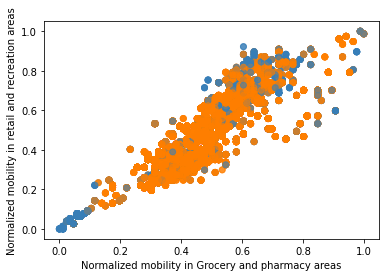

In [188]:
# Groceries and pharmacy mobility
svm = OneClassSVM(gamma=0.003, nu=0.1)
svm.fit(train)
x = test['grocery_and_pharmacy']
y = test['retail_and_recreation'] 
y_pred = svm.predict(test) 
colors = np.array(['#377eb8', '#ff7f00']) 
plt.scatter(x, y, alpha=0.6, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized mobility in Grocery and pharmacy areas') 
plt.ylabel('Normalized mobility in retail and recreation areas')

Text(0, 0.5, 'Normalized mobility in parks')

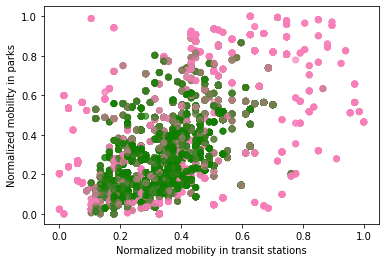

In [189]:
# Transit stations and parks mobility
svm = OneClassSVM(gamma=0.3, nu=0.3)
svm.fit(train)
x = test['transit_stations']
y = test['parks'] 
y_pred = svm.predict(test) 
colors = np.array(['#f77eb8', '#0f7f00']) 
plt.scatter(x, y, alpha=0.4, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized mobility in transit stations') 
plt.ylabel('Normalized mobility in parks')

Text(0, 0.5, 'Normalized mobility in retail and recreation')

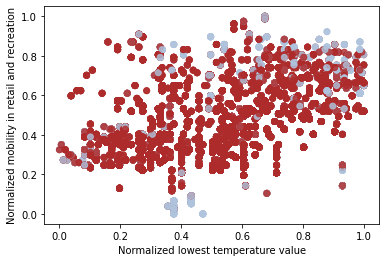

In [190]:
# Low temperature and retail/recreation mobility
svm = OneClassSVM(gamma=0.00001, nu=0.1)
svm.fit(train)
x = test['daily_low_tempature']
y = test['retail_and_recreation'] 
y_pred = svm.predict(test) 
colors = np.array(['#B0C4DE', '#AE2B2B']) 
plt.scatter(x, y, alpha=0.8, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized lowest temperature value') 
plt.ylabel('Normalized mobility in retail and recreation')

Text(0, 0.5, 'Normalized mobility in retail and recreation')

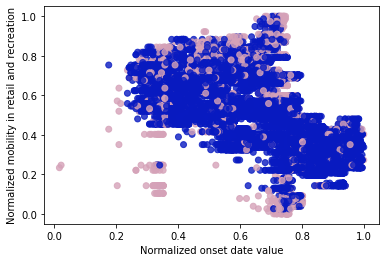

In [191]:
# Date and retail/recreation mobility
svm = OneClassSVM(gamma=1, nu=0.1)
svm.fit(train)
x = test['date_id']
y = test['retail_and_recreation'] 
y_pred = svm.predict(test) 
colors = np.array(['#D5A2B8', '#081AC1']) 
plt.scatter(x, y, alpha=0.8, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized onset date value') 
plt.ylabel('Normalized mobility in retail and recreation')

Text(0, 0.5, 'Normalized mobility in retail and recreation')

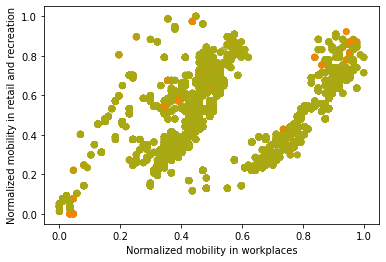

In [192]:
# Workplaces and retail/recreation mobility
svm = OneClassSVM(gamma=1, nu=0.01)
svm.fit(train)
x = test['workplaces']
y = test['retail_and_recreation'] 
y_pred = svm.predict(test) 
colors = np.array(['#ff7f00', '#A9A913']) 
plt.scatter(x, y, alpha=0.8, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized mobility in workplaces') 
plt.ylabel('Normalized mobility in retail and recreation')

Text(0, 0.5, 'Normalized mobility in workplaces')

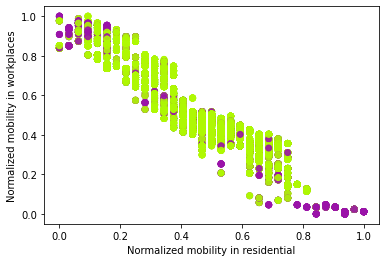

In [193]:
# Workplaces and retail/recreation mobility
svm = OneClassSVM(gamma=0.005, nu=0.1)
svm.fit(train)
x = test['residential']
y = test['workplaces'] 
y_pred = svm.predict(test) 
colors = np.array(['#9A13A9', '#AFF903']) 
plt.scatter(x, y, alpha=0.9, c=colors[(y_pred + 1) // 2]) 
plt.xlabel('Normalized mobility in residential') 
plt.ylabel('Normalized mobility in workplaces')